In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torch import cuda

from util.model_validator import ModelValidator
from util.bert_trainer import BertTrainer
from util.review_dataset import ReviewDataset
from util.bert_class import BertClass

torch.manual_seed(1234)  # Für Vergleichbarkeit der Modelle
device = 'cuda' if cuda.is_available() else 'cpu'  # GPU benutzen

In [2]:
label_mapping = {"CG": 1, "OR": 0}
data = pd.read_csv("./resources/fake_reviews_dataset.csv")
data["label_index"] = data["label"].map(label_mapping)
data = data[['text', 'label', 'label_index']].copy()
data.head()

,text,label,label_index
0,"Love this! Well made, sturdy, and very comfor...",CG,1
1,"love it, a great upgrade from the original. I...",CG,1
2,This pillow saved my back. I love the look and...,CG,1
3,"Missing information on how to use it, but it i...",CG,1
4,Very nice set. Good quality. We have had the s...,CG,1


In [3]:
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 4
MAX_TEXT_LEN = 512
EPOCHS = 10
LEARNING_RATE = 1e-05

In [4]:
train_dataset = data.sample(frac=0.8, random_state=200)  # Train: 80%
valid_dataset = data.drop(train_dataset.index).sample(frac=0.75, random_state=200)  # Valid: 15%
test_dataset = data.drop(train_dataset.index) \
    .drop(valid_dataset.index).reset_index(drop=True)  # Test: 5%
train_dataset = train_dataset.reset_index(drop=True)
valid_dataset = valid_dataset.reset_index(drop=True)

print("FULL Dataset: {}".format(data.shape[0]))
print("===============================")
print("TRAIN Dataset: {}".format(train_dataset.shape[0]))
print("VALID Dataset: {}".format(valid_dataset.shape[0]))
print("TEST Dataset: {}".format(test_dataset.shape[0]))

train_set = ReviewDataset(train_dataset, MAX_TEXT_LEN)
valid_set = ReviewDataset(valid_dataset, MAX_TEXT_LEN)

train_loader = DataLoader(train_set, batch_size=TRAIN_BATCH_SIZE)
valid_loader = DataLoader(valid_set, batch_size=VALID_BATCH_SIZE)

FULL Dataset: 40432
TRAIN Dataset: 32346
VALID Dataset: 6064
TEST Dataset: 2022


In [5]:
learning_rates = [5e-04, 1e-04, 5e-05, 1e-05, 5e-06]
dropout_rates = [0.1, 0.2, 0.3, 0.4, 0.5]

for lr in learning_rates:
    for drp in dropout_rates:
        model = BertClass(dropout=drp)
        model.to(device)

        optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
        trainer = BertTrainer(model, optimizer, train_loader, valid_loader)
        loss_list, val_loss_list = trainer.train(EPOCHS)

# model = BertClass()
# model.to(device)
# optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)
# trainer = BertTrainer(model, optimizer, train_loader, valid_loader)
# loss_list, val_loss_list = trainer.load('model_bert_ep10_lr1e-05_drp0.1.pth')

Start training... lr: 0.0005, drp: 0.1
Epoch: 1, Loss: 0.6998270006977486, Valid. Loss: 0.7131806140210194
Epoch: 2, Loss: 0.6950257381776203, Valid. Loss: 0.693403326112551
Epoch: 3, Loss: 0.6942048629950345, Valid. Loss: 0.6932335272627959
Epoch: 4, Loss: 0.6940200566420097, Valid. Loss: 0.6931651530290971
Epoch: 5, Loss: 0.6939683145042933, Valid. Loss: 0.6931345308676244
Epoch: 6, Loss: 0.6939461008524919, Valid. Loss: 0.6931276784565958
Epoch: 7, Loss: 0.693906846462678, Valid. Loss: 0.6931321851339063
Epoch: 8, Loss: 0.6939482361549911, Valid. Loss: 0.6931321484117835
Epoch: 9, Loss: 0.6938906069531757, Valid. Loss: 0.6931257941870702
Epoch: 10, Loss: 0.6938869617989933, Valid. Loss: 0.6931261317239273
Model training time: 5.73h
Start training... lr: 0.0005, drp: 0.2
Epoch: 1, Loss: 0.7140727217661993, Valid. Loss: 0.7164448737154535
Epoch: 2, Loss: 0.7080097664239734, Valid. Loss: 0.7012266497026962
Epoch: 3, Loss: 0.7023589298880772, Valid. Loss: 0.6942735479893973
Epoch: 4, Lo

Final Test Accuracy: 97.394 %
Last Train Loss: 2.711974229896441e-05



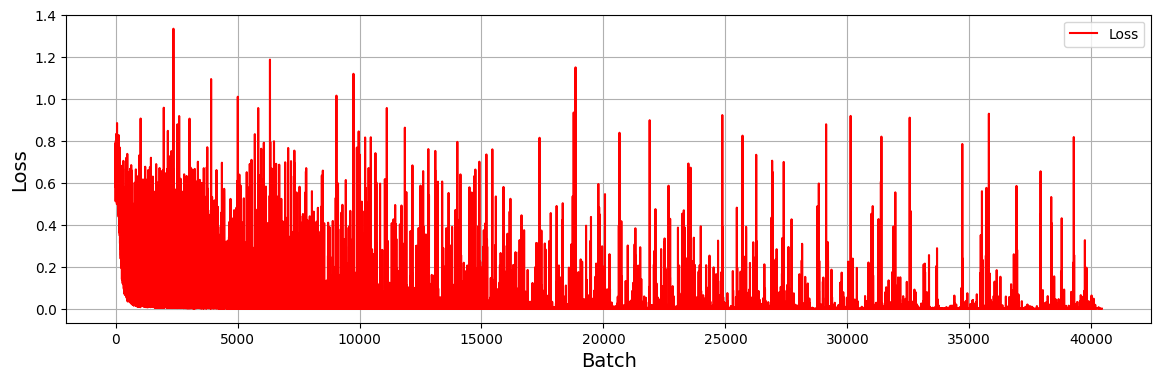

In [6]:
model_validator = ModelValidator(model, valid_loader)
accuracy = model_validator.calc_accuracy()

print('Final Test Accuracy:', accuracy, '%')
print('Last Train Loss:', loss_list[-1])
print()
plt.figure(figsize=(14, 4))
plt.plot(range(len(loss_list)), loss_list, '-r', label='Loss')
plt.grid()
plt.legend()
plt.xlabel('Batch', size=14)
plt.ylabel('Loss', size=14)
plt.show()

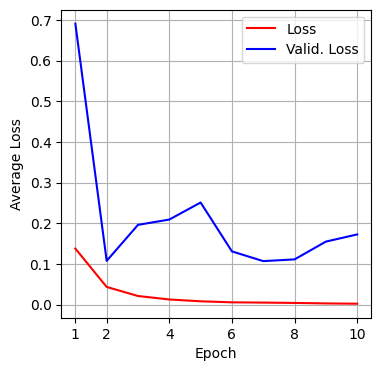

In [7]:
losses_per_epoch = int(len(loss_list) / EPOCHS)
losses_array = np.array(loss_list).reshape(-1, losses_per_epoch)
avg_loss = np.mean(losses_array, axis=1)

plt.figure(figsize=(4, 4))
plt.plot(range(1, len(avg_loss) + 1), avg_loss, '-r', label='Loss')
plt.plot(range(1, len(val_loss_list) + 1), val_loss_list, '-b', label='Valid. Loss')
plt.grid()
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.xticks([1] + list(plt.xticks()[0][1:-1]))
plt.show()

Model loaded: model_bert_ep10_lr0.0005_drp0.1.pth
Last loss: 0.6924666166305542
Model training time: 5.73h
Model loaded: model_bert_ep10_lr0.0005_drp0.2.pth
Last loss: 0.691065788269043
Model training time: 5.68h
Model loaded: model_bert_ep10_lr0.0005_drp0.3.pth
Last loss: 0.6917296051979065
Model training time: 5.69h
Model loaded: model_bert_ep10_lr0.0005_drp0.4.pth
Last loss: 0.696692168712616
Model training time: 5.69h
Model loaded: model_bert_ep10_lr0.0005_drp0.5.pth
Last loss: 0.6907639503479004
Model training time: 5.69h
Model loaded: model_bert_ep10_lr0.0001_drp0.1.pth
Last loss: 0.6469376087188721
Model training time: 5.71h
Model loaded: model_bert_ep10_lr0.0001_drp0.2.pth
Last loss: 0.7339497804641724
Model training time: 5.74h
Model loaded: model_bert_ep10_lr0.0001_drp0.3.pth
Last loss: 0.6841567754745483
Model training time: 5.75h
Model loaded: model_bert_ep10_lr0.0001_drp0.4.pth
Last loss: 0.7157622575759888
Model training time: 5.72h
Model loaded: model_bert_ep10_lr0.0001_

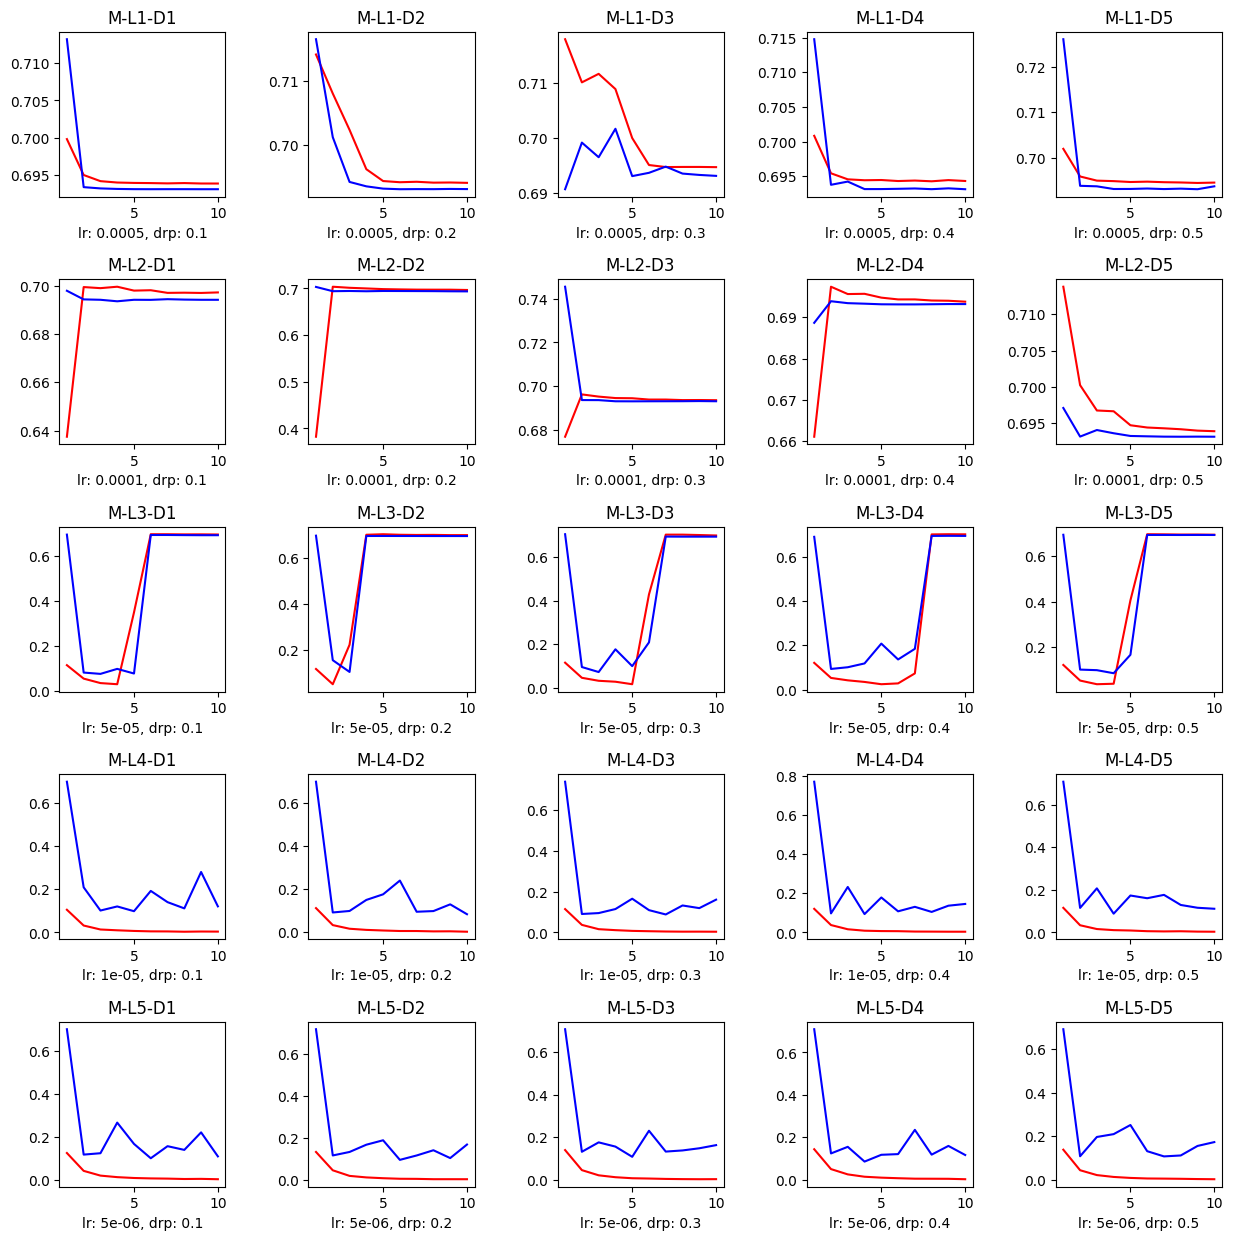

In [8]:
fig, axs = plt.subplots(5, 5, figsize=(15, 15))

lr = learning_rates
drp = dropout_rates
model_evals = []

for y in range(5):
    for x in range(5):
        loss_list, val_loss_list = trainer.load(f'model_bert_ep{str(EPOCHS)}_lr{str(lr[y])}_drp{str(drp[x])}.pth')
        avg_loss = np.mean(np.array(loss_list).reshape(-1, int(len(loss_list) / EPOCHS)), axis=1)
        model_name = f'M-L{y+1}-D{x+1}'
        model_acc = ModelValidator(model, valid_loader).calc_accuracy()
        model_evals.append((model_name, val_loss_list[-1], model_acc))
        axs[y, x].plot(range(1, len(avg_loss) + 1), avg_loss, '-r', label='Loss')
        axs[y, x].plot(range(1, len(val_loss_list) + 1), val_loss_list, '-b', label='Valid. Loss')
        axs[y, x].set_title(model_name)
        axs[y, x].set_xlabel(f'lr: {lr[y]}, drp: {drp[x]}')

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

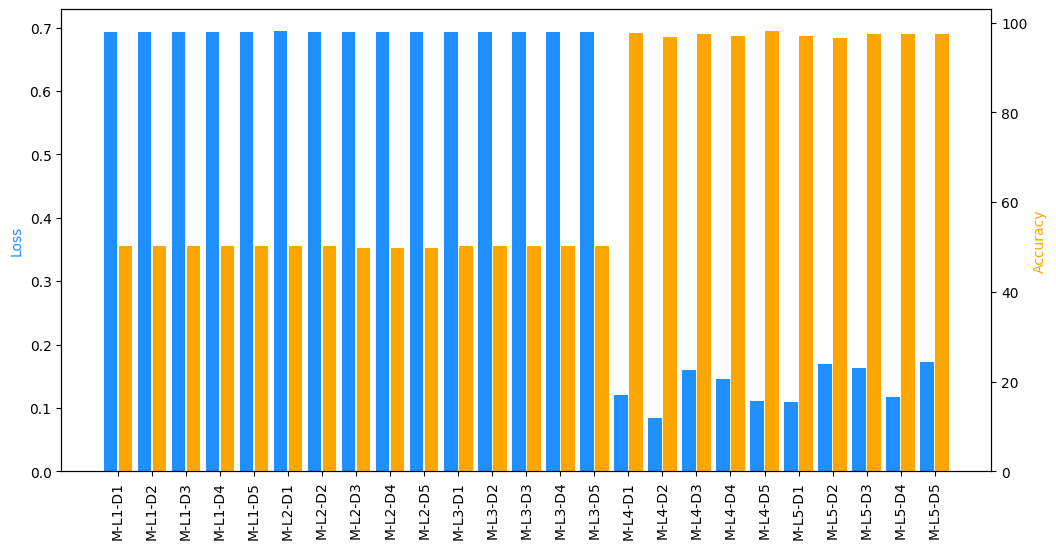

In [9]:
model_labels = [mvl[0] for mvl in model_evals]
model_val_loss = [mvl[1] for mvl in model_evals]
model_acc = [mvl[2] for mvl in model_evals]

bar_width = 0.4
x = np.arange(len(model_labels))
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.bar(x - bar_width*0.55, model_val_loss, bar_width, color='dodgerblue')
ax1.set_ylabel('Loss', color='dodgerblue')
ax2 = ax1.twinx()
ax2.bar(x + bar_width*0.55, model_acc, bar_width, color='orange')
ax2.set_ylabel('Accuracy', color='orange')

ax1.set_xticks(x)
ax1.set_xticklabels(model_labels, rotation=90)
plt.show()